In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models,Input,preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the dataset
## a) Keras mnist dataset
The keras library has a pre-implemented dataset for the mnist images.
The `load_data` function already splits the data in train and test sets.

In [59]:
# Load the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape) # train set, 60 000 entries
print(x_test.shape) # test set, 10 000 entries

(60000, 28, 28)
(10000, 28, 28)


## b) Data augmentation
Enriching a dataset is a good way of optimizing a model's performance.
Data-augmentation is a concept in which more data is generated from an existing set.
As described in [Chris Deotte's post](https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist), the mnist dataset can be augmented by manipulating the data through subtle transformations of rotation, scaling and translation.

In [60]:
# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape inputs for data generation
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Initialize the data generator
datagen.fit(x_train)
datagen_generator = datagen.flow(x_train, y_train, batch_size=32)

In [61]:
# The number of images to generate
augment_size = 30000
x_augmented = np.zeros((augment_size, 28, 28, 1))
y_augmented = np.zeros((augment_size, 10))

# Accumulator for the number of samples processed
data_processed = 0

# Generate augmented data
while data_processed < augment_size:
    x_batch, y_batch = next(datagen_generator)
    batch_size = x_batch.shape[0]

    if data_processed + batch_size > augment_size:
        batch_size = data_processed + batch_size - augment_size
                
        x_augmented[data_processed:data_processed+batch_size] = x_batch[:batch_size]
        y_augmented[data_processed:data_processed+batch_size] = y_batch[:batch_size]
    else:
        x_augmented[data_processed:data_processed+batch_size] = x_batch
        y_augmented[data_processed:data_processed+batch_size] = y_batch
    
    data_processed += batch_size

# Remove channel dimension for training
x_train = np.concatenate([x_train, x_augmented])
y_train = np.concatenate([y_train, y_augmented])

# Resizing the output for the train
x_train = x_train.reshape((x_train.shape[0], 28, 28))

print(x_train.shape)
print(y_train.shape)

(90000, 28, 28)
(90000, 10)


# 2. Model implementation
The keras library makes it really easy to implement convolutional neural network.
One of the most popular choices for handwritten digits recognition neural networks is Yann Lecun's LeNet-5 architecture.

In [62]:
model = models.Sequential([
        # Input Layer
        layers.Input(shape=(28, 28, 1)),
        
        # C1 Convolutional Layer
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', padding='same'),
        
        # S2 Pooling Layer
        layers.AvgPool2D(pool_size=(2, 2), strides=2),
        
        # C3 Convolutional Layer
        layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
        
        # S4 Pooling Layer
        layers.AvgPool2D(pool_size=(2, 2), strides=2),
        
        # C5 Fully Connected Convolutional Layer
        layers.Conv2D(filters=120, kernel_size=(5, 5), activation='relu'),
        
        # Flatten the CNN output to feed it with fully connected layers
        layers.Flatten(),
        
        # F6 Fully Connected Layer
        layers.Dense(units=84, activation='relu'),
        
        # Output Layer with softmax activation for classification
        layers.Dense(units=10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

# 3. Training

In [63]:
x_valid = x_train[:10000]
y_valid = y_train[:10000]
x_train = x_train[10000:x_train.shape[0]]
y_train = y_train[10000:y_train.shape[0]]

history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_valid, y_valid)
)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8375 - loss: 0.5132 - val_accuracy: 0.9721 - val_loss: 0.0936
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9690 - loss: 0.0989 - val_accuracy: 0.9829 - val_loss: 0.0532
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9806 - loss: 0.0620 - val_accuracy: 0.9846 - val_loss: 0.0439
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9852 - loss: 0.0470 - val_accuracy: 0.9876 - val_loss: 0.0394
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9878 - loss: 0.0363 - val_accuracy: 0.9873 - val_loss: 0.0380
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9902 - loss: 0.0312 - val_accuracy: 0.9887 - val_loss: 0.0350
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9917 - loss: 0.0255 - val_accuracy: 0.9906 - val_loss: 0.0308
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9922 - loss: 0.0234 - 

# 4. Resulting plots

<Axes: >

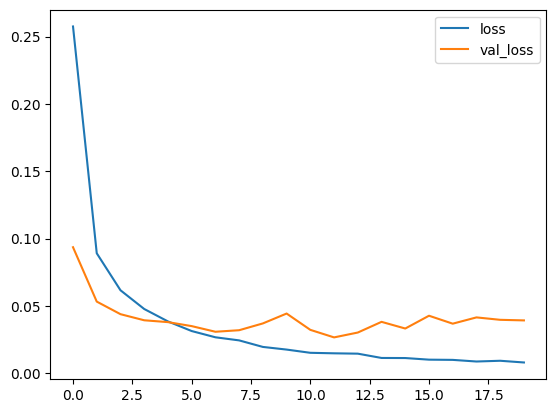

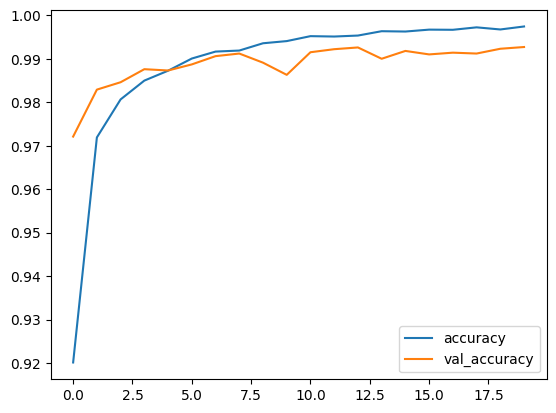

In [64]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['accuracy','val_accuracy']].plot()

# 6. TEST PREPROCESSING + Model Prediction

In [67]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


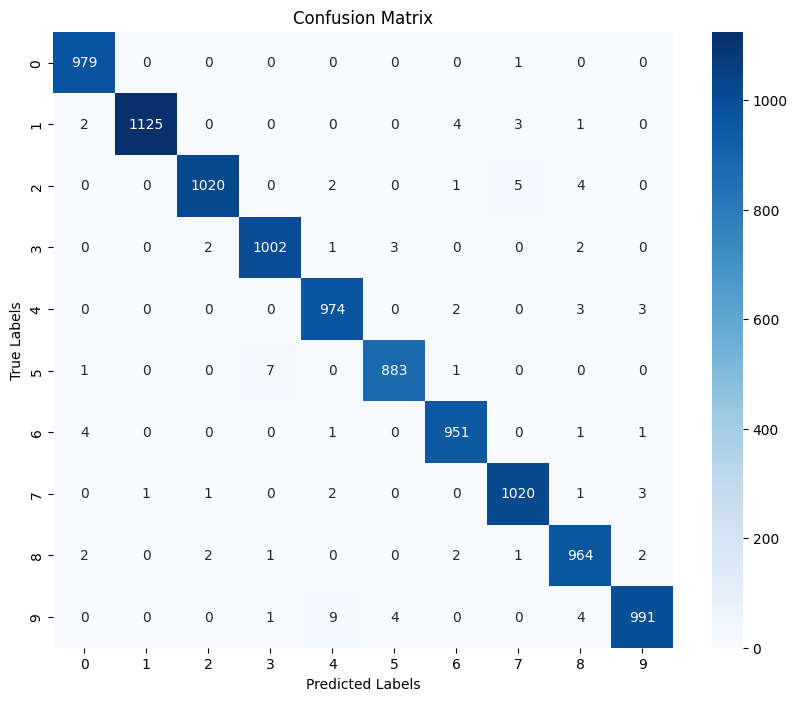

In [66]:
# Predict classes
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 7. Saving the model

In [68]:
model.save('digit_recognizer.h5')